## Text Classification for the IMDB Dataset using BERT.
In this notebook we build a binarry classifier for the IMDB Reviews Dataset using [BERT](https://arxiv.org/abs/1810.04805), a pre-Trained NLP model open soucred by google in late 2018 that can be used for [Transfer Learning](https://towardsdatascience.com/transfer-learning-in-nlp-fecc59f546e4) on textual data. The link for the dataset can be found [here](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).<br>
This notebook requires a GPU to get setup. We suggest you to run this on your local machine only if you have a GPU setup or else you can use google colab.

In [ ]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore") 

# install BERT
!pip install pytorch_pretrained_bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [0]:
# uploading the dataset
from google.colab import files
uploaded = files.upload()


Saving IMDB Dataset.csv to IMDB Dataset.csv


In [0]:
df = pd.read_csv("IMDB Dataset.csv",engine='python', error_bad_lines=False)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [0]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])


In [0]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [0]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df['review']=df['review'].apply(strip)



In [0]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,Petter Mattei's Love in the Time of Money is a...,1


BERT expects input data in a specific format
1. We are performing a classification task so we use a special token [CLS] to indicate this to BERT.
2. It needs to know the end of a sentence so we use the [SEP] token.

In [0]:
#BERT needs to understand 2 things:
#1) The start and end of each sentiment
# so we declare a special token CLS which tells BERT that its a classification task
sentences = df['review']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [0]:
sentence[0]

"[CLS] One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked They are right, as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO Trust me, this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs, sex or violence Its is hardcore, in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda Em City is home to manyAryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and moreso scuffles, death stares, dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldn't da

We now need to tokenize our text into tokens that correspond to BERT’s vocabulary.

In [0]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', '1', 'oz', 'episode', 'you', "'", 'll', 'be', 'hooked', 'they', 'are', 'right', ',', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'met', '##he', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'un', '##fl', '##in', '##ching', 'scenes', 'of', 'violence', ',', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', ',', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'tim', '##id', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', ',', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', ',', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '##it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'pen', '##ite', '##nta', '##ry', 'it', 'focuses', 'mainl

In [0]:
labels = list(df['sentiment'])#storing the labels

We now need to give BERT input ids,ie, a sequence of integers which uniquely identify each input token to its index number.

In [0]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, tokenized_texts)),
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")



In [0]:
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

BERT is a MLM(Masked Language Model). We have to define its mask.

In [0]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)
  

Now we need to split the data into train and validation. Convert it to tensors and then create iterator for our data

In [0]:
# Select a batch size for training. 
batch_size = 16

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



In [0]:
#Loading pre trained BERT
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)#binary classification
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

Finally, we move onto the Fine-Tuning of BERT.

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.5862126989568885


Epoch:  25%|██▌       | 1/4 [14:34<43:42, 874.07s/it]

Validation Accuracy: 0.7619808306709265
Train loss: 0.46202650182862914


Epoch:  50%|█████     | 2/4 [29:08<29:08, 874.15s/it]

Validation Accuracy: 0.8117012779552716
Train loss: 0.4168417638719315


Epoch:  75%|███████▌  | 3/4 [43:41<14:33, 873.95s/it]

Validation Accuracy: 0.8306709265175719
Train loss: 0.37315769140253363


Epoch: 100%|██████████| 4/4 [58:15<00:00, 873.90s/it]

Validation Accuracy: 0.8140974440894568


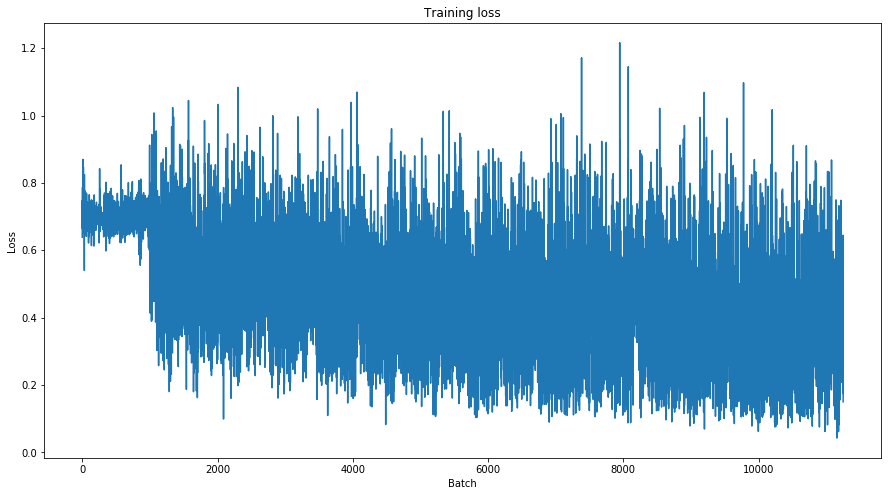

In [0]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()